<a href="https://colab.research.google.com/github/VadymKalin/ml/blob/main/Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Voting Classifier
2. Bagging Classifier
3. Random Forest
4. Boosting

# **VOTING**

In [1]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X,y = make_moons(n_samples=500,noise=0.30,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr',LogisticRegression(random_state=42)),
         ('svc',SVC(random_state=42)),
          ('dt',DecisionTreeClassifier(random_state=42))],
    voting='hard'
)

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42))])

In [2]:
from os import XATTR_CREATE
for name,clf in voting_clf.named_estimators_.items():
    print(f"{name}={clf.score(X_test,y_test)}")

lr=0.864
svc=0.896
dt=0.856


In [3]:
voting_clf.score(X_test,y_test)

0.904

In [4]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr',LogisticRegression(random_state=42)),
         ('svc',SVC(random_state=42)),
          ('dt',DecisionTreeClassifier(random_state=42))],
    voting='soft'
)

In [5]:
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train,y_train)
voting_clf.score(X_test,y_test)

0.912

# **BUGGING**

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

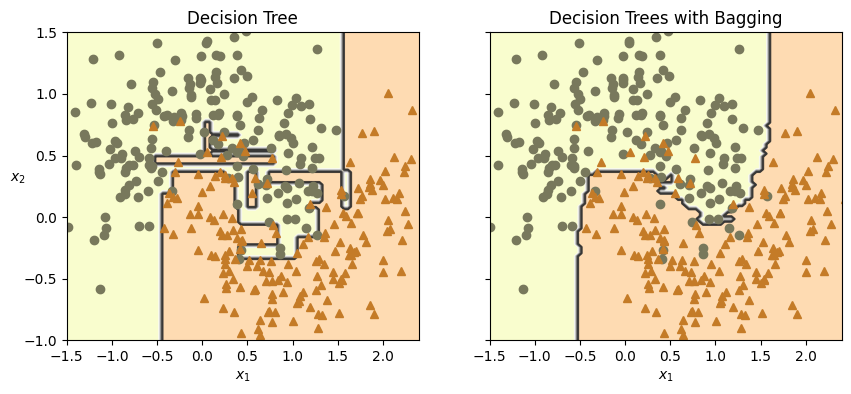

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()


In [8]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_


0.896

In [9]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.92

# **Random Forest**